# Interpreting Language Models with Contrastive Explanations
### ___Kayo Yin and Graham Neubig___
This Colab notebook lets you visualize contrastive explanations for language model decisions, based on [Yin and Neubig (2022)](https://arxiv.org/abs/2202.10419).





In [1]:
#@title #**Setup Environment**
#@markdown Install and import Python dependencies.

print('Importing libraries...')
import sys
sys.path.append('./interpret-lm')
from lm_saliency import *

print('Done!')

if not torch.cuda.is_available():
  print("Please restart runtime with GPU")

Importing libraries...


/Users/first_principle/opt/anaconda3/envs/scan/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Done!
Please restart runtime with GPU


In [2]:
#@markdown #**Load Language Model**
model_name = "gpt-2" #@param ["gpt-2", "gpt-neo"]

if model_name == "gpt-2":
  tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
  model = GPT2LMHeadModel.from_pretrained("gpt2")
elif model_name == "gpt-neo":
  model = GPTNeoForCausalLM.from_pretrained("EleutherAI/gpt-neo-1.3B")
  tokenizer = GPT2Tokenizer.from_pretrained("EleutherAI/gpt-neo-1.3B")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [11]:
#@markdown #**Define Input**
input = "Can you stop the dog from" #@param {type:"string"}
input = input.strip() + " "
input_tokens = tokenizer(input)['input_ids']
attention_ids = tokenizer(input)['attention_mask']

preds = model_preds(model, [input_tokens], [attention_ids], -1, tokenizer, foils=None, k=10, verbose=True)

NameError: name 'model_preds' is not defined

input_id1 [6090, 345, 2245, 262, 3290, 422, 220]
input_id2 [6090, 345, 2245, 262, 3290, 422]
A.logits 6


/Users/first_principle/opt/anaconda3/envs/scan/lib/python3.9/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


input_id1 [6090, 345, 2245, 262, 3290, 422, 220]
input_id2 [6090, 345, 2245, 262, 3290, 422]
A.logits 6


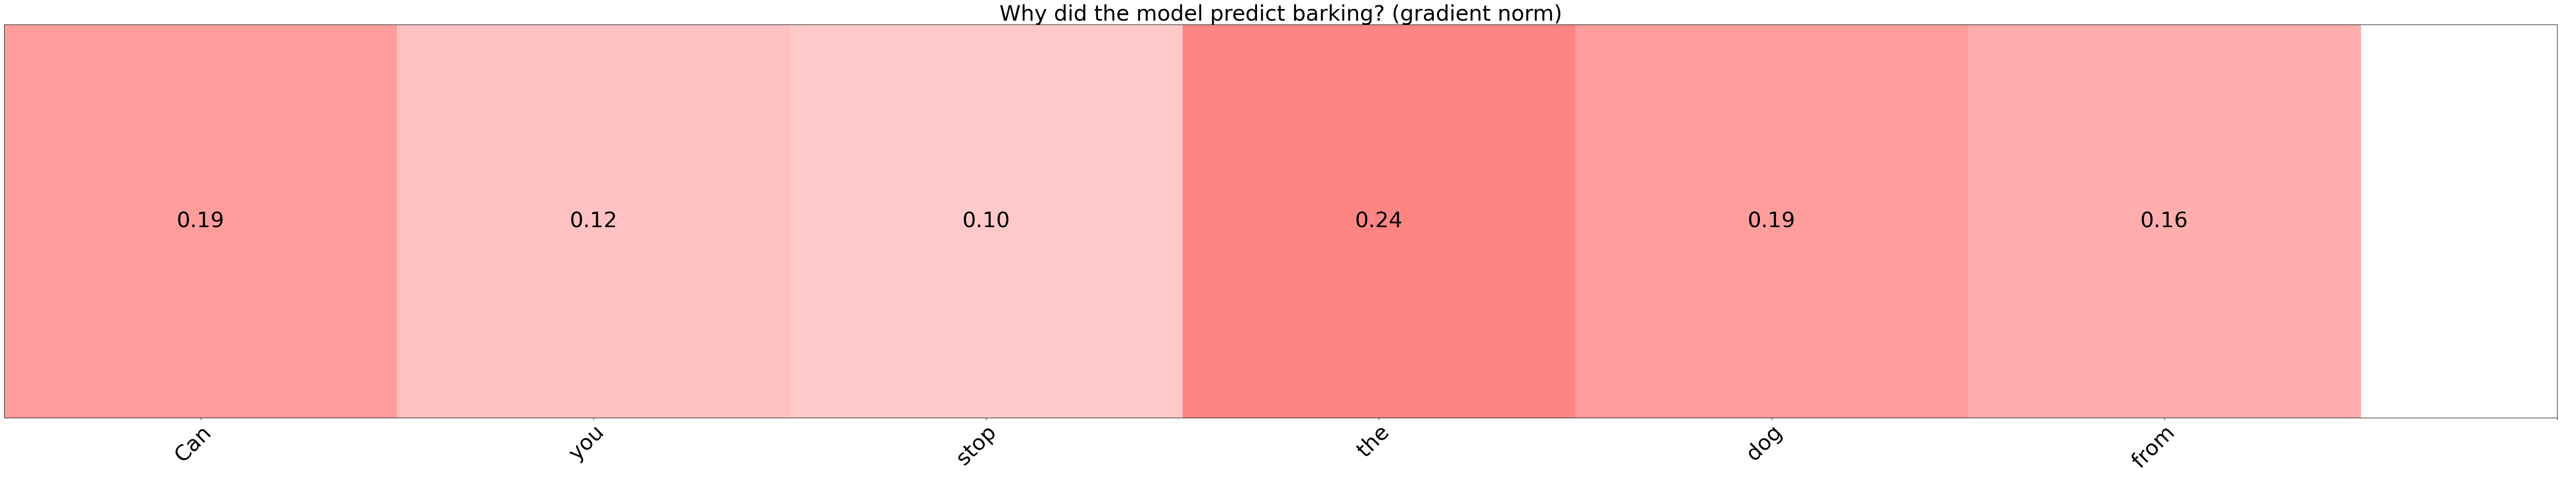

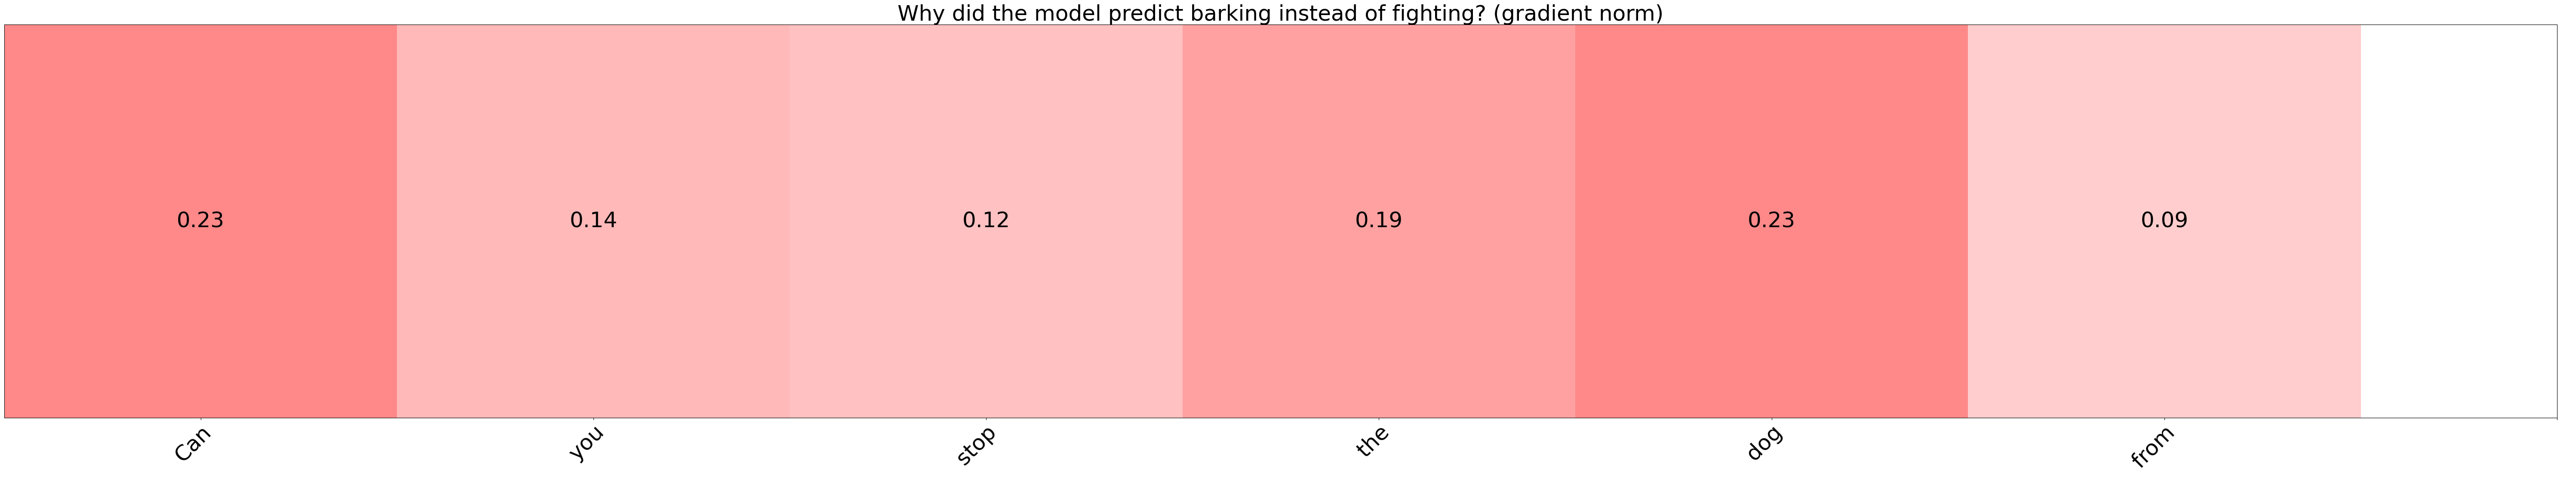

In [4]:
#@markdown #**Visualize Explanations**
target = "barking" #@param {type:"string"}
foil = "fighting" #@param {type:"string"}
explanation = "gradient norm" #@param ["input x gradient", "gradient norm", "erasure"]

CORRECT_ID = tokenizer(" "+ target)['input_ids'][0]
FOIL_ID = tokenizer(" "+ foil)['input_ids'][0]

if explanation == "erasure":
  base_explanation = erasure_scores(model, input_tokens, attention_ids, normalize=True)
  contra_explanation = erasure_scores(model, input_tokens, attention_ids, correct=CORRECT_ID, foil=FOIL_ID, normalize=True)
else:
  base_saliency_matrix, base_embd_matrix = saliency(model, input_tokens, attention_ids)
  saliency_matrix, embd_matrix = saliency(model, input_tokens, attention_ids, foil=FOIL_ID)
  if explanation == "input x gradient":
    base_explanation = input_x_gradient(base_saliency_matrix, base_embd_matrix, normalize=True)
    contra_explanation = input_x_gradient(saliency_matrix, embd_matrix, normalize=True)
  elif explanation == "gradient norm":
    base_explanation = l1_grad_norm(base_saliency_matrix, normalize=True)
    contra_explanation = l1_grad_norm(saliency_matrix, normalize=True)

visualize(np.array(base_explanation), tokenizer, [input_tokens], print_text=True, title=f"Why did the model predict {target}? ({explanation})")
visualize(np.array(contra_explanation), tokenizer, [input_tokens], print_text=True, title=f"Why did the model predict {target} instead of {foil}? ({explanation})")



# seq

In [1]:
from saliency import *
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")
input_seq = "Can you stop the dog from" 
output_seq = "barking loudly"

# tokenize output sequences
output_tokens = tokenizer(output_seq)['input_ids']

# add whitespace to input_seq for tokens in output_seq
input_seq = input_seq.strip() + " " * (len(output_tokens))

# tokenize input sequence
input_tokens = tokenizer(input_seq)['input_ids']
attention_ids = tokenizer(input_seq)['attention_mask']

/Users/first_principle/opt/anaconda3/envs/scan/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# merge tokens into words, word_value should be the average of token values
def merge_tokens(tokens, token_values):
    words = []
    word_value = 0
    word = ""
    for token in tokens:
        if token.startswith("Ġ"):
            if word_value != 0:
                words.append((word_value, word))
            word = token[1:]
            word_value = token_values[token]
        else:
            word += token
            word_value += token_values[token]
    words.append((word_value, word))
    return words
sentence = "Can you stop the dog from barking loudly bad-temperedly?"
tokens = tokenizer.tokenize(sentence)
# assign a value to each token
values = np.random.rand(len(tokens))
# create a dictionary with token:value pairs
token_values = dict(zip(tokens, values))
# merge tokens into words
words = merge_tokens(tokens, token_values)
# print the words and their values

words

[(0.06101610687519787, 'Can'),
 (0.4438191908346396, 'you'),
 (0.038717642384950124, 'stop'),
 (0.5709700444439068, 'the'),
 (0.7545450090105847, 'dog'),
 (0.8701956610953923, 'from'),
 (0.618589485526579, 'barking'),
 (0.07956882857884473, 'loudly'),
 (2.349215680886861, 'bad-temperedly?')]

In [9]:
token_values

{'Can': 0.06101610687519787,
 'Ġyou': 0.4438191908346396,
 'Ġstop': 0.038717642384950124,
 'Ġthe': 0.5709700444439068,
 'Ġdog': 0.7545450090105847,
 'Ġfrom': 0.8701956610953923,
 'Ġbarking': 0.618589485526579,
 'Ġloudly': 0.07956882857884473,
 'Ġbad': 0.6281325312521483,
 '-': 0.06179877437635917,
 'tem': 0.22098028616564747,
 'pered': 0.25863545911576635,
 'ly': 0.2819048251581633,
 '?': 0.8977638048187765}

In [10]:
base_saliency_matrix, base_embd_matrix = seq_saliency(model, input_tokens, attention_ids, output_tokens)
base_explanation = input_x_gradient(base_saliency_matrix, base_embd_matrix, normalize=True)
visualize(np.array(base_explanation), tokenizer, [input_tokens], print_text=True, title=f"Why did the model predict {output_seq}? (input x gradient)")

TypeError: seq_saliency() missing 1 required positional argument: 'output_ids'

In [7]:
output_tokens = torch.tensor(output_tokens, dtype=torch.long).to(model.device)
len(output_tokens)

/var/folders/ng/jh0twkn55sbds4qg4kkndgq80000gn/T/ipykernel_5248/850122465.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output_tokens = torch.tensor(output_tokens, dtype=torch.long).to(model.device)


4